# 1. Imports and Loading the Network

The graph is loaded from the `sbb.edgelist`.
Make sure to create this edgelist through the `create_edgelist.py` script.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

In [3]:
print(f"number of nodes: {len(G.nodes)}")
print(f"number of edges: {len(G.edges)}")

number of nodes: 3152
number of edges: 4678


In [4]:
connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
print("Number of nodes in largest connected component:", len(max_connected_comp))

G_lcc = G.subgraph(max_connected_comp)

Number of nodes in largest connected component: 3017


# 2. Community Detection


In [5]:
import random

def community_stats(communities, algorithm_name):
    comms_len = [len(c) for c in communities]
    print(f"{algorithm_name}: number of communities: {len(communities)}")
    print(f"{algorithm_name}: size of each community: {comms_len}")


def plot_communities(G, communities, algorithm_name):
    getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = getcolors(len(communities))

    plt.figure(figsize=(12, 9))    
    pos = nx.spring_layout(G, seed=42)     
    for i, c in enumerate(communities):
        nx.draw_networkx_nodes(     
            G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
        )            

    nx.draw_networkx_edges(G, pos=pos, width=0.20, alpha=0.33)
    plt.title(f"{algorithm_name} Community Detection")
    plt.show()

## 2.1 Louvain

### 2.1.1 Louvain on the Entire Graph

In [6]:
louvain = nx.community.louvain_communities(G, seed=42)

community_stats(louvain, "Louvain")

Louvain: number of communities: 57
Louvain: size of each community: [98, 93, 131, 47, 25, 20, 26, 222, 15, 13, 117, 13, 30, 32, 12, 19, 137, 55, 83, 45, 18, 24, 99, 156, 51, 18, 20, 43, 12, 50, 3, 98, 27, 24, 74, 103, 38, 128, 20, 29, 17, 9, 202, 2, 212, 50, 50, 94, 20, 20, 79, 29, 64, 12, 7, 10, 7]


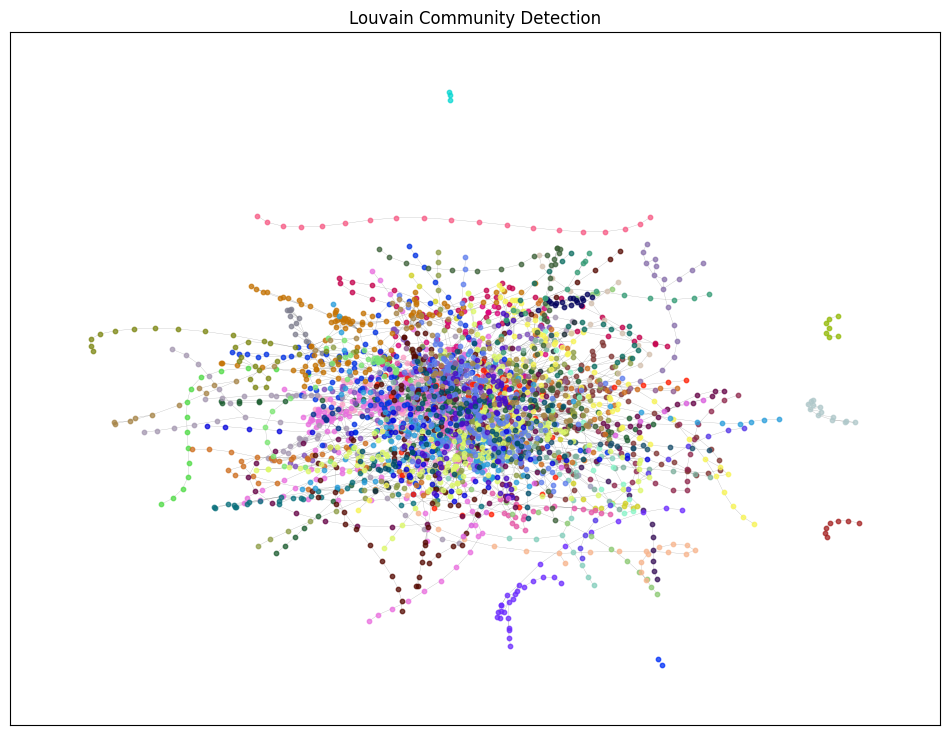

In [7]:
plot_communities(G, louvain, "Louvain")

### 2.1.2 Louvain with Largest Connected Components

In [8]:
louvain = nx.community.louvain_communities(G_lcc, seed=42)

community_stats(louvain, "Louvain LCC")       

Louvain LCC: number of communities: 45
Louvain LCC: size of each community: [93, 27, 18, 116, 116, 15, 13, 151, 79, 61, 121, 85, 134, 104, 45, 156, 135, 15, 23, 32, 51, 18, 20, 135, 43, 27, 25, 24, 19, 38, 113, 50, 72, 17, 202, 28, 43, 20, 56, 50, 29, 117, 20, 50, 211]


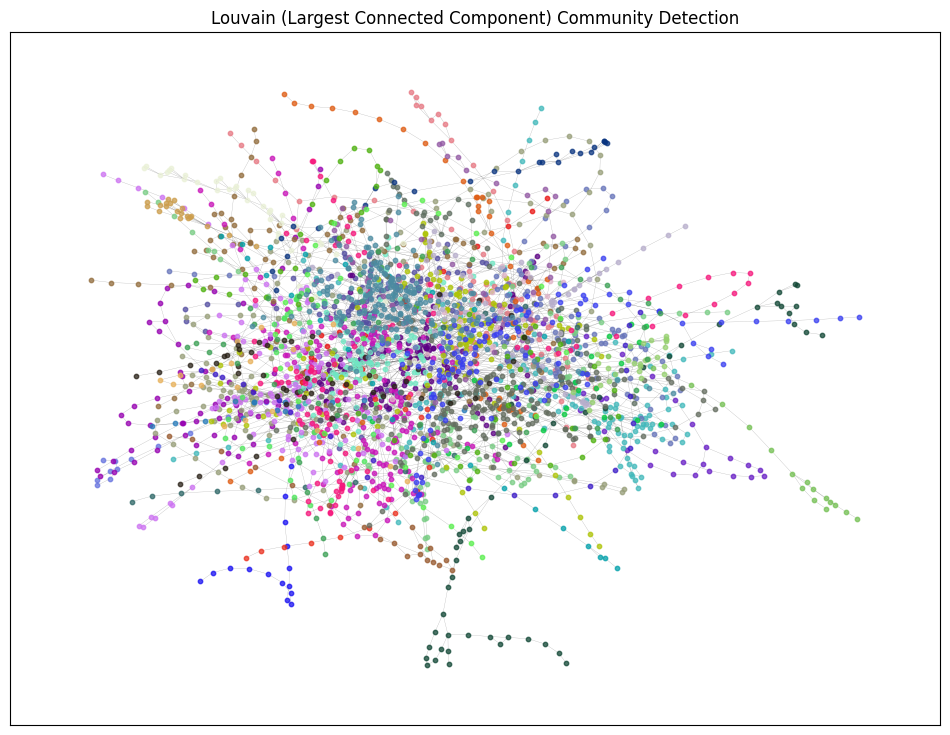

In [9]:
plot_communities(G_lcc, louvain, "Louvain (Largest Connected Component)")

### 2.1.3 Louvain: Our Implementation

In [10]:
from louvain import louvain_implementation

G_lcc = nx.Graph(G_lcc)
louvain_imp = louvain_implementation(G_lcc)

community_stats(louvain_imp, "Louvain Implementation (Largest Connected Component)")

65
final communities: [{'Lattigen bei Spiez', 'Vernayaz', 'Wimmis', 'Orsières', 'Innertkirchen Kraftwerk (Bahn)', 'Hohtenn', 'Stresa', 'Burglauenen', 'Sion', 'Martigny', 'Les Evouettes', 'Martigny-Expo', 'St-Maurice', 'Leuk', 'Meiringen', 'Bovernier', 'Preglia', 'Meiringen Alpbach', 'Frutigen', 'St-Gingolph (Suisse)', 'Lütschental', 'Sembrancher', 'Bex-Place-du-Marché', 'Bex', 'Mülenen', 'Brienz', 'Lauterbrunnen', 'Ardon', 'Oey-Diemtigen', 'Grindelwald', 'Saxon', 'Eggerberg', 'Salgesch', 'Le Châble VS', 'Reichenbach im Kandertal', 'La Douay', 'Martigny-Croix', 'Chamoson-St-Pierre-de-Clages', 'Goppenstein', 'Innertkirchen Grimseltor', 'Domodossola (I)', 'Niederried', 'Sierre/Siders', 'Brig', 'Zweilütschinen', 'Aareschlucht Ost (Bahn)', 'St-Léonard', 'Ringgenberg', 'Gampel-Steg', 'Visp', 'Ausserberg', 'Interlaken Ost', 'Varzo', 'Turtmann', 'Monthey', 'Vouvry', 'Brienzwiler', 'Riddes', 'Matten b. Interlaken', 'Raron', 'Martigny-Bourg', 'Burgholz', 'Ebligen', 'Grindelwald Terminal', 'Charr

ImportError: cannot import name 'louvain_implementation' from 'louvain' (/home/matt/Documents/university/master/semester01/sma/project/sbb-analytics/louvain.py)

In [ ]:
plot_communities(G_lcc, louvain_imp, "Louvain Implementation (Largest Connected Component)")

## 2.2 Girvan-Newman

In [ ]:
import time

def girvan_newman(G, time_threshold=1):
    gn_communities = nx.community.girvan_newman(G)

    iter_count = 0
    coms = []

    # Apply Girvan-Newman iteratively for > time_threshold hour
    timeout = time.time() + 60 * time_threshold
    while True:
        if time.time() > timeout:
            break
        
        iter_count += 1
        coms = next(gn_communities, 'end')

    print(f'number of iterations: {iter_count}')
    return coms


gn = girvan_newman(G_lcc, time_threshold=8)

In [ ]:
community_stats(gn, "Girvan Newman (Largest Connected Component)")

In [ ]:
plot_communities(G_lcc, gn, "Girvan Newman (Largest Connected Component)")

## 2.3 Leiden

In [11]:
import leidenalg as la
import igraph as ig

def leiden_communities(G):
    graph = ig.Graph.from_networkx(G, vertex_attr_hashable='name')

    partition = list(la.find_partition(graph, la.ModularityVertexPartition))
    # convert back the node ids to node names
    idx2name = {idx: name for idx, name in enumerate(list(G.nodes))}
    communities = []
    for comm in partition:
        communities.append({idx2name[n] for n in comm})
        
    return communities

In [12]:
leiden = leiden_communities(G_lcc)

community_stats(leiden, "Leiden (Largest Connected Component)")

Leiden (Largest Connected Component): number of communities: 52
Leiden (Largest Connected Component): size of each community: [164, 142, 137, 131, 124, 121, 119, 112, 108, 102, 98, 89, 89, 88, 83, 81, 73, 68, 66, 65, 61, 56, 53, 51, 50, 49, 44, 44, 41, 38, 37, 32, 32, 29, 27, 25, 24, 24, 20, 20, 20, 20, 19, 18, 18, 17, 16, 15, 15, 15, 14, 13]


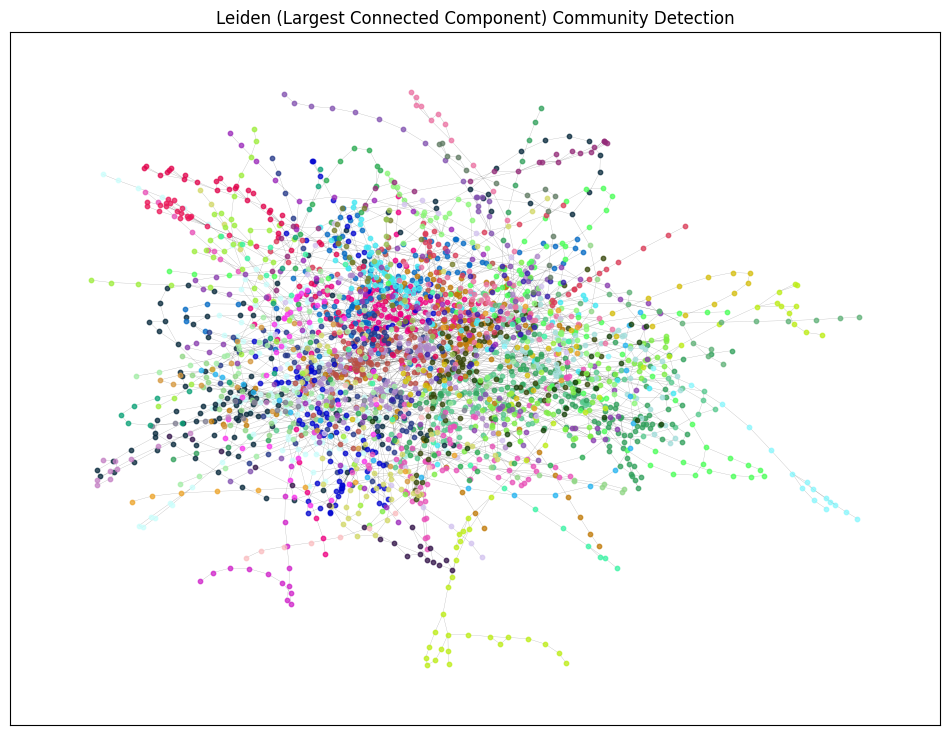

In [13]:
plot_communities(G_lcc, leiden, "Leiden (Largest Connected Component)")